# Project tiles

 - split boreal tiles by dateline and create new updated geopackage
 - create aggregated (AGG) tiles for GEE exports

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
from shapely.geometry import box
import matplotlib.pyplot as plt 
import numpy as np
import os, sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils

NASA MAAP


## Make a new version of the Boreal Tiles vector

In [2]:
UPDATED_BOREAL_TILES_VERSION = 'v004'

In [3]:
# Start with the existing file
boreal_tiles = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003.gpkg')

### Dateline tiles in existing v003 tiles cause problems

Text(0.5, 1.0, 'Boreal tiles (v003) with dateline tiles in red')

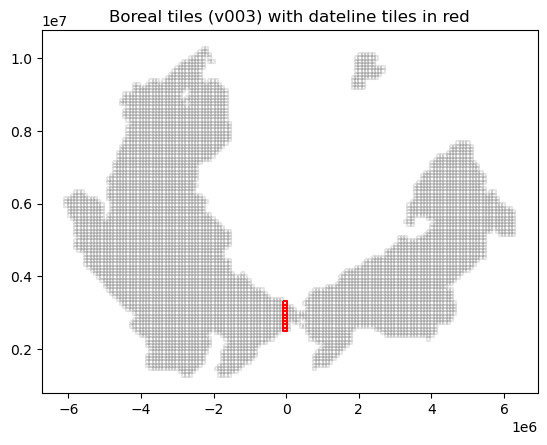

In [4]:
# dateline (bad) tiles
dateline_tiles = [3540,3634,3728,3823,3916,4004,41995,41807,41619]

ax = boreal_tiles.boundary.plot(color='black', alpha=0.1)
boreal_tiles[boreal_tiles['tile_num'].isin(dateline_tiles)].boundary.plot(ax=ax, ec='red')
ax.set_title(f'Boreal tiles (v003) with dateline tiles in red')

#### Functions to split tiles on dateline

In [5]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, LineString
from shapely.ops import unary_union

def create_date_line_polygon(buffer_distance=0.00001):
    """
    Create a polygon representing the international date line buffered by a given distance.

    Parameters:
    - buffer_distance (float): Distance to buffer the international date line. Default is 0.00005 dd - about 5m in the boreal.

    Returns:
    - geopandas.GeoDataFrame: GeoDataFrame with the buffered international date line polygon.
    """
    # Create a LineString representing the international date line
    date_line = LineString([(-180, -89.99), (-180, 89.99)])

    # Buffer the line to create a polygon
    date_line_polygon = date_line.buffer(buffer_distance)

    # Create a GeoDataFrame with the buffered polygon
    gdf_date_line = gpd.GeoDataFrame(geometry=[date_line_polygon], crs='EPSG:4326')

    return gdf_date_line

def split_polygon(polygon, crs):
    """
    Split a polygon by the international date line.

    Parameters:
    - polygon (shapely.geometry.Polygon): Polygon to be split.

    Returns:
    - List of shapely.geometry.Polygon: List of split polygons.
    """
    date_line = create_date_line_polygon().to_crs(crs).geometry[0]
    
    parts = []
    if polygon.intersects(date_line):
        # Split the polygon
        parts = list(polygon.difference(date_line).geoms) 
    else:
        parts.append(polygon)

    return parts

def split_polygons_by_dateline_poly(gdf, tile_num_col='tile_num', DO_BOREAL_TILES_COLS=False):
    """
    Split polygons in a GeoDataFrame by the international date line.

    Parameters:
    - gdf (geopandas.GeoDataFrame): GeoDataFrame with polygons to be split.

    Returns:
    - geopandas.GeoDataFrame: GeoDataFrame with split polygons.
    """
    # Ensure the GeoDataFrame has a valid geometry column
    if 'geometry' not in gdf.columns or gdf['geometry'].isna().any():
        raise ValueError("The GeoDataFrame must have a valid 'geometry' column with polygons.")

    # Split polygons by the international date line
    split_polygons = []
    centroid_gdf_list = []
    tile_num_list = []
    if 'tile_group' in gdf.columns and 'tile_version' in gdf.columns: DO_BOREAL_TILES_COLS = True
    if DO_BOREAL_TILES_COLS:
        tile_group_list = []
        tile_version_list = []
    for _, row in gdf.iterrows():
        original_polygon = row['geometry']
        tile_num = row[tile_num_col]
        centroid_gdf = gpd.GeoDataFrame(data=[row], geometry=[row['geometry'].centroid], crs=gdf.crs) # this will help carry through attributes
        if original_polygon.geom_type == 'Polygon':
            # Handle a single Polygon
            split_parts = split_polygon(original_polygon, crs=gdf.crs)
        elif original_polygon.geom_type == 'MultiPolygon':
            # Handle MultiPolygon
            split_parts = [split_polygon(part, crs=gdf.crs) for part in original_polygon]
        else:
            raise ValueError(f"Unsupported geometry type: {original_polygon.geom_type}")

        split_polygons.extend(split_parts)
        centroid_gdf_list.append(centroid_gdf)
        for part in split_parts:
            if tile_num in tile_num_list:
                # New split polys are scaled by 100 from original tile_num values
                tile_num = tile_num * 100
            tile_num_list.append(tile_num)
            
            if DO_BOREAL_TILES_COLS:
                tile_group_list.append(row['tile_group'])
                tile_version_list.append(row['tile_version'])

    # Create a new GeoDataFrame with split polygons
    gdf_split = gpd.GeoDataFrame(geometry=split_polygons, crs=gdf.crs)
    gdf_split = gpd.sjoin(gdf_split, pd.concat(centroid_gdf_list), how='left')
    gdf_split[tile_num_col] = tile_num_list
    if DO_BOREAL_TILES_COLS:
        gdf_split['tile_group'] = tile_group_list
        gdf_split['tile_version'] = tile_version_list
    return gdf_split

### Map the dateline and tiles
This shows the problem of how in prj 4326 the tiles crossing the dateline extend across the globe instead of extending across teh dateline

In [6]:
date_line = create_date_line_polygon(buffer_distance=0.00001) # about 1 m in boreal
boreal_tiles_dateline = boreal_tiles[boreal_tiles['tile_num'].isin(dateline_tiles)]

In [8]:
m = boreal_tiles_dateline.explore()
date_line.explore(m=m, color='red')

### Split tiles by dateline
##### show for the subset of dateline tiles only (proof of concept)

In [7]:
# Split polygons by the international date line
boreal_tiles_dateline_split = split_polygons_by_dateline_poly(boreal_tiles_dateline)

# Fic tile_num col etc
boreal_tiles_dateline_split = boreal_tiles_dateline_split[boreal_tiles_dateline_split['tile_num'].notna()].drop(['index_right'], axis=1)
boreal_tiles_dateline_split['tile_num'] = boreal_tiles_dateline_split['tile_num'].apply(lambda x: int(x) if x == x else "")

boreal_tiles_dateline_split

geometry  tile_num tile_version  \
0   POLYGON ((-0.429 3033304.000, -0.442 2943304.0...      3540    version 1   
1   POLYGON ((8522.000 3033304.000, 8522.000 29433...    354000    version 1   
2   POLYGON ((-0.442 2943304.000, -0.455 2853304.0...      3634    version 1   
3   POLYGON ((8522.000 2943304.000, 8522.000 28533...    363400    version 1   
4   POLYGON ((-0.455 2853304.000, -0.469 2763304.0...      3728    version 1   
5   POLYGON ((8522.000 2853304.000, 8522.000 27633...    372800    version 1   
6   POLYGON ((-0.469 2763304.000, -0.482 2673304.0...      3823    version 1   
7   POLYGON ((8522.000 2763304.000, 8522.000 26733...    382300    version 1   
8   POLYGON ((-0.482 2673304.000, -0.496 2583304.0...      3916    version 1   
9   POLYGON ((8522.000 2673304.000, 8522.000 25833...    391600    version 1   
10  POLYGON ((-0.496 2583304.000, -0.509 2493304.0...      4004    version 1   
11  POLYGON ((8522.000 2583304.000, 8522.000 24933...    400400    version 1   
12  POLYGON ((-0.388 3303304.000, -0.402 3213304.0...     41619    version 2   
13  POLYGON ((8522.000 3303304.000, 8522.000 32133...   4161900    version 2   
14  POLYGON ((-0.402 3213304.000, -0.415 3123304.0...     41807    version 2   
15  POLYGON ((8522.000 3213304.000, 8522.000 31233...   4180700    version 2   
16  POLYGON ((-0.415 3123304.000, -0.429 3033304.0...     41995    version 2   
17  POLYGON ((8522.000 3123304.000, 8522.000 30333...   4199500    version 2   

       tile_group  map_version  
0    eurasia east          NaN  
1    eurasia east          NaN  
2    eurasia east          NaN  
3    eurasia east          NaN  
4    eurasia east          NaN  
5    eurasia east          NaN  
6    eurasia east          NaN  
7    eurasia east          NaN  
8    eurasia east          NaN  
9    eurasia east          NaN  
10   eurasia east          NaN  
11   eurasia east          NaN  
12  eurasia north          NaN  
13  eurasia north          NaN  
14  eurasia north          NaN  
15  eurasia north          NaN  
16  eurasia north          NaN  
17  eurasia north          NaN

### Map the split tiles  
This shows the fixed tiles! Zoom in at the dateline to inspect.

In [10]:
m = boreal_tiles_dateline_split.explore()
date_line.explore(m=m, color='red')

## Apply to boreal tiles vector
##### Make an updated boreal tiles vector with split dateline tiles

In [8]:
# Split polygons by the international date line
boreal_tiles_updated = split_polygons_by_dateline_poly(boreal_tiles)

# Fic tile_num col etc
boreal_tiles_updated = boreal_tiles_updated[boreal_tiles_updated['tile_num'].notna()].drop(['index_right'], axis=1)
boreal_tiles_updated['tile_num'] = boreal_tiles_updated['tile_num'].apply(lambda x: int(x) if x == x else "")
boreal_tiles_updated['map_version'] = 'none'
boreal_tiles_updated.explore()

## Export the updated boreal tiles vector

In [9]:
# Remove tile 23 (crosses meridian)
boreal_tiles_updated = boreal_tiles_updated[~boreal_tiles_updated.tile_num.isin([23, 24064])]

In [13]:
boreal_tiles_updated.to_file(f'/projects/my-public-bucket/databank/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}.gpkg', driver='GPKG')

## Create final agg tile

In [10]:
length_m_boreal_tile = int(boreal_tiles.iloc[1].geometry.length/4)
length_m_boreal_tile

90000

In [11]:
# number of boreal tiles to aggregate
AGG_FACTOR = 12 #8

In [12]:
CRS_AGG_TILES = boreal_tiles.crs
#CRS_AGG_TILES = 4326

In [13]:
# Get the extent of the shapefile
total_bounds = boreal_tiles.total_bounds
minX, minY, maxX, maxY = total_bounds
print(total_bounds)
x, y = (minX, minY)
geom_array = []

square_size = length_m_boreal_tile * AGG_FACTOR

while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

[-6111478.00000001  1233304.00000001  6308521.99999999 10323304.00000001]


In [14]:
print(f'Setting agg tiles crs to: {CRS_AGG_TILES}')

Setting agg tiles crs to: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [15]:
boreal_tiles_agg_new = gpd.GeoDataFrame(geom_array, columns=['geometry'], crs=boreal_tiles.crs).to_crs(CRS_AGG_TILES)
boreal_tiles_agg_new['agg_tile_num'] = boreal_tiles_agg_new.index + 1

In [16]:
boreal_tiles_agg_new.head()

geometry  agg_tile_num
0  POLYGON ((-6111478.000 1233304.000, -6111478.0...             1
1  POLYGON ((-5031478.000 1233304.000, -5031478.0...             2
2  POLYGON ((-3951478.000 1233304.000, -3951478.0...             3
3  POLYGON ((-2871478.000 1233304.000, -2871478.0...             4
4  POLYGON ((-1791478.000 1233304.000, -1791478.0...             5

### Update boreal agg tiles with only tiles that intersect the boreal tiles

In [17]:
boreal_tiles_agg_new_intersect = gpd.overlay(boreal_tiles_agg_new, boreal_tiles.to_crs(CRS_AGG_TILES), how='intersection')
boreal_agg_tiles = list(set(boreal_tiles_agg_new_intersect.agg_tile_num.to_list()))
len(boreal_agg_tiles)

/tmp/ipykernel_1245/3465032764.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1031 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  boreal_tiles_agg_new_intersect = gpd.overlay(boreal_tiles_agg_new, boreal_tiles.to_crs(CRS_AGG_TILES), how='intersection')


65

In [18]:
boreal_tiles_agg_new_updated = boreal_tiles_agg_new[boreal_tiles_agg_new.agg_tile_num.isin(boreal_agg_tiles)]
boreal_tiles_agg_new_updated.shape

(65, 2)

### Clip boreal agg tiles by dissolved boreal tiles

##### this clip seems to impose a dateline clip

In [19]:
DO_DATELINE_CLIP = False

In [20]:
boreal_tiles_updated_diss = boreal_tiles_updated.dissolve('map_version')[['geometry']].explode().reset_index()
boreal_tiles_agg_new_updated = gpd.clip(boreal_tiles_agg_new_updated, boreal_tiles_updated_diss).explode()
boreal_tiles_agg_new_updated['isLine'] = boreal_tiles_agg_new_updated.apply(lambda row: False if row['geometry'].geom_type != 'LineString' else True, axis=1)
boreal_tiles_agg_new_updated = boreal_tiles_agg_new_updated.loc[boreal_tiles_agg_new_updated['isLine'] == False].reset_index()#.drop(['level_1'])
boreal_tiles_agg_new_updated.explore()

/tmp/ipykernel_1245/2388863052.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boreal_tiles_updated_diss = boreal_tiles_updated.dissolve('map_version')[['geometry']].explode().reset_index()
/tmp/ipykernel_1245/2388863052.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boreal_tiles_agg_new_updated = gpd.clip(boreal_tiles_agg_new_updated, boreal_tiles_updated_diss).explode()


In [21]:
boreal_tiles_agg_new_updated[boreal_tiles_agg_new_updated.agg_tile_num == 3].explore()

Text(0.5, 1.0, 'Updated boreal tiles v004 & aggregate tiles (AGG factor = 12)')

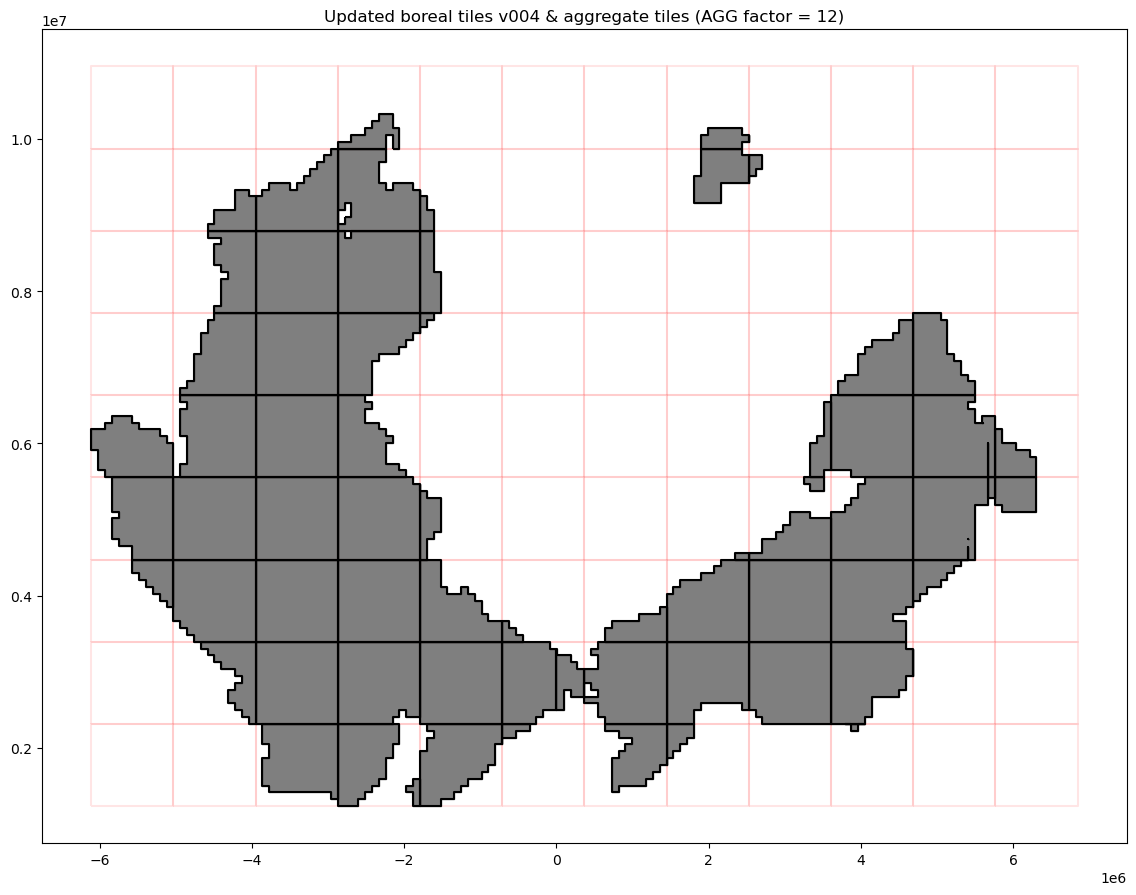

In [22]:
ax = boreal_tiles_agg_new.boundary.plot(color='red', alpha=0.1, figsize=(14,14))
#ax = boreal_tiles_updated_diss.boundary.plot(ax=ax, color='green', alpha=0.25)
ax = boreal_tiles_agg_new_updated.boundary.plot(ax=ax, color='black')
ax = boreal_tiles_agg_new_updated.plot(ax=ax, color='black', ec='black', alpha=0.5)
ax.set_title(f'Updated boreal tiles {UPDATED_BOREAL_TILES_VERSION} & aggregate tiles (AGG factor = {AGG_FACTOR})')

## Do dateline split on the updated boreal agg tiles

In [23]:
if DO_DATELINE_CLIP:
    # Split polygons by the international date line
    boreal_tiles_agg_new_updated_dateline = split_polygons_by_dateline_poly(boreal_tiles_agg_new_updated, tile_num_col='agg_tile_num')#drop('index_right')
    
    ## Fix tile_num col etc
    #boreal_tiles_agg_new_updated_dateline = boreal_tiles_agg_new_updated_dateline[boreal_tiles_agg_new_updated_dateline['agg_tile_num'].notna()].drop(['index_right'], axis=1)
    #boreal_tiles_agg_new_updated_dateline['agg_tile_num'] = boreal_tiles_agg_new_updated_dateline['agg_tile_num'].apply(lambda x: int(x) if x == x else "")
else:
    boreal_tiles_agg_new_updated_dateline = boreal_tiles_agg_new_updated
    
boreal_tiles_agg_new_updated_dateline['agg_tile_num'] = boreal_tiles_agg_new_updated_dateline.index + 1
boreal_tiles_agg_new_updated_dateline

level_0  level_1  agg_tile_num  \
0         7        0             1   
1         6        0             2   
2         3        0             3   
3         3        1             4   
4         5        0             5   
..      ...      ...           ...   
64       85        0            65   
65       86        0            66   
66       99        0            67   
67      103        0            68   
68      104        0            69   

                                             geometry  isLine  
0   POLYGON ((1448522.000 2313304.000, 1808522.000...   False  
1   POLYGON ((1448522.000 2313304.000, 1448522.000...   False  
2   POLYGON ((-2871478.000 2313304.000, -2151478.0...   False  
3   POLYGON ((-1791478.000 1233304.000, -1881478.0...   False  
4   POLYGON ((-711478.000 2313304.000, -351478.000...   False  
..                                                ...     ...  
64  POLYGON ((-3951478.000 8793304.000, -4581478.0...   False  
65  POLYGON ((-3951478.000 9243304.000, -3951478.0...   False  
66  POLYGON ((-2151478.000 9873304.000, -2151478.0...   False  
67  POLYGON ((2528522.000 9963304.000, 2438522.000...   False  
68  POLYGON ((2528522.000 10053304.000, 2528522.00...   False  

[69 rows x 5 columns]

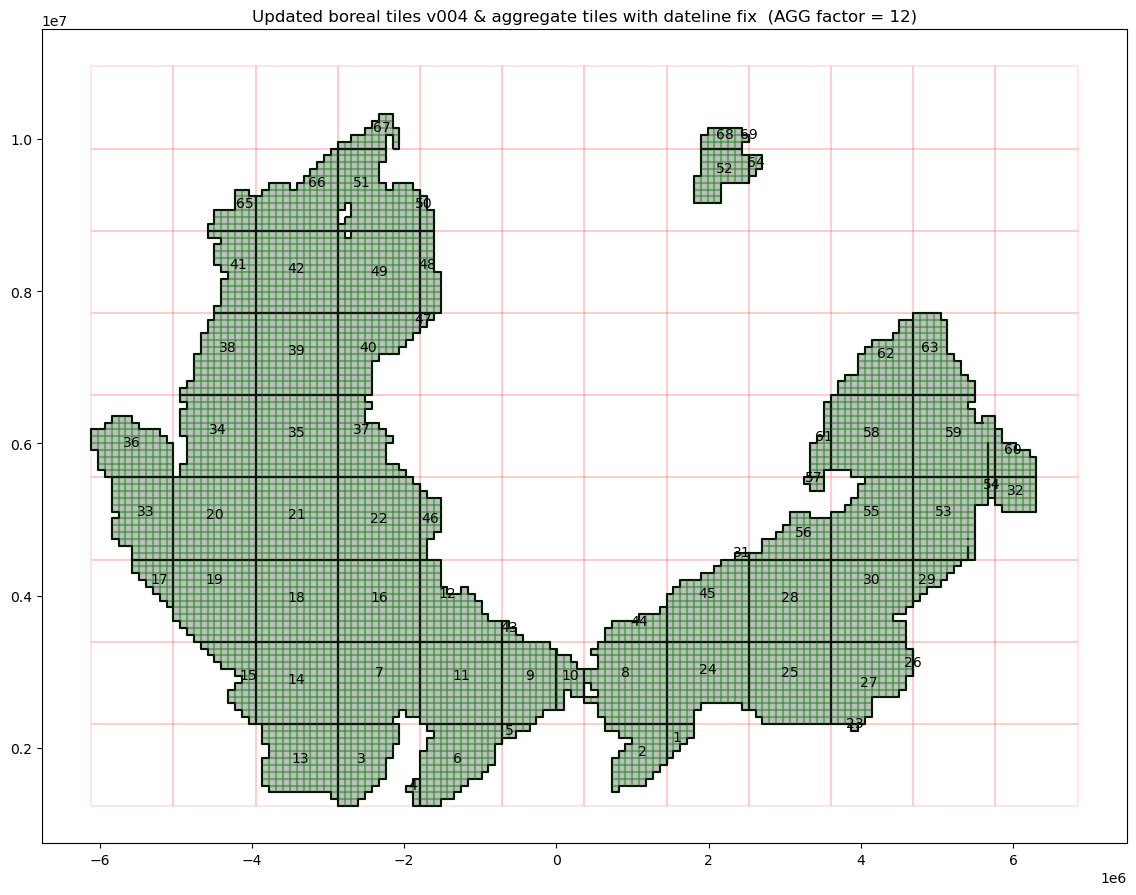

In [24]:
np.random.seed(0)
ax = boreal_tiles_agg_new.boundary.plot(color='red', alpha=0.1, figsize=(14,14))
ax = boreal_tiles_agg_new_updated_dateline.boundary.plot(color='black', ax=ax)
#ax = bad_agg_tile.plot(ax=ax, color='black')
ax = boreal_tiles_updated.boundary.plot(ax=ax, color='green', alpha=0.25)
#ax = boreal_tiles_agg_new_updated_dateline.plot(ax=ax, column='agg_tile_num', color = [np.random.choice(list(mcolors.CSS4_COLORS.values())) for i in range(400)] )
ax = boreal_tiles_agg_new_updated_dateline.plot(ax=ax, color='black', alpha=0.25)
ax.set_title(f'Updated boreal tiles {UPDATED_BOREAL_TILES_VERSION} & aggregate tiles with dateline fix  (AGG factor = {AGG_FACTOR})')

if True:
    tmp = boreal_tiles_agg_new_updated_dateline.copy()
    tmp.boundary.plot(ax=ax, ec='black', alpha = 0.25)
    
    tmp['coords'] = tmp['geometry'].apply(lambda x: x.representative_point().coords[:])
    tmp['coords'] = [coords[0] for coords in tmp['coords']]

    for idx, row in tmp.iterrows():
        plt.annotate(text=row['agg_tile_num'], xy=row['coords'],horizontalalignment='center')

In [25]:
boreal_tiles_agg_new_updated_dateline.tail()

level_0  level_1  agg_tile_num  \
64       85        0            65   
65       86        0            66   
66       99        0            67   
67      103        0            68   
68      104        0            69   

                                             geometry  isLine  
64  POLYGON ((-3951478.000 8793304.000, -4581478.0...   False  
65  POLYGON ((-3951478.000 9243304.000, -3951478.0...   False  
66  POLYGON ((-2151478.000 9873304.000, -2151478.0...   False  
67  POLYGON ((2528522.000 9963304.000, 2438522.000...   False  
68  POLYGON ((2528522.000 10053304.000, 2528522.00...   False

In [26]:
boreal_tiles_agg_new_updated_dateline.explore()

In [27]:
print(f"{len(boreal_tiles_agg_new_updated_dateline)} agg tiles (AGG factor = {AGG_FACTOR}) you'll have to export from GEE for each year's seasonal composite")

69 agg tiles (AGG factor = 12) you'll have to export from GEE for each year's seasonal composite


## Export AGGREGATE tiles for GEE SAR S1 asset transfers

In [79]:
OUT_TILES_GDF = boreal_tiles_agg_new_updated_dateline
OUTDIR = f'/projects/shared-buckets/montesano/databank/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}'
!mkdir -p $OUTDIR

In [81]:
OUT_TILES_GDF.to_crs(4326).to_file(f'{OUTDIR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}_4326.shp' )
OUT_TILES_GDF.to_crs(3857).to_file(f'{OUTDIR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}_3857.shp' )
OUT_TILES_GDF.to_file(f'{OUTDIR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}.gpkg' )

/tmp/ipykernel_27819/2329660397.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  OUT_TILES_GDF.to_crs(4326).to_file(f'{OUTDIR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}_4326.shp' )
/tmp/ipykernel_27819/2329660397.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  OUT_TILES_GDF.to_crs(3857).to_file(f'{OUTDIR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}_3857.shp' )


In [31]:
print(OUT_TILES_GDF.crs)


PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## Next: 
#### - upload to GEE 
#### - choose a year and run exports: `https://code.earthengine.google.com/?scriptPath=users%2Fmmacander%2Fveg_structure%3Asentinel_1%2Fseasonal_s1_tile_export_v2`
#### - build subtiles below

## Build a footprint of subtiles that are expected

Putting these 'expected' subtiles in `databank` but `MAKE_ASSET_TILE_SUBTILES()` also run in `DPS_gee_export.ipynb` and written to `my-public-bucket/DPS_tile_lists/SAR/EXPORT_GEE_v2/SAR_S1_2018/S1_AGG_TILE_NUM_subtiles.gpkg`

### Make subtiles from the boreal aggregate tiles
these are needed for the DPS of the GEE asset transfers to MAAP

In [46]:
import importlib
import do_gee_download_by_subtile
importlib.reload(do_gee_download_by_subtile)
importlib.reload(ExtractUtils)
YEAR = 2019

NASA MAAP


In [47]:
#### If DPSing by subtile, you need ASSET_PATH to get gee asset_df and TILELOC to get the tile form asset_df to make its fishnet even before you call 'do_gee_download_by_subtile'
ASSET_PATH = f'projects/foreststructure/Circumboreal/S1_triseason_albers_{YEAR}'

# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

TILE_FIELD_NAME = 'AGG_TILE_NUM'
TILE_SIZE_M = 500

In [35]:
# fishnet_4326_list = []
# TILE_LIST = asset_df.AGG_TILE_NUM.to_list()
# for AGG_TILE_NUM in TILE_LIST:
#     print(AGG_TILE_NUM)
#     ASSET_TILE_NAME, fishnet_4326 = ExtractUtils.MAKE_ASSET_TILE_SUBTILES(AGG_TILE_NUM, asset_df, TILE_FIELD_NAME=TILE_FIELD_NAME, TILE_SIZE_M=TILE_SIZE_M)
#     fishnet_4326_list.append(fishnet_4326)

# S1_subtiles = pd.concat(fishnet_4326_list)
# S1_subtiles.to_file(f'/projects/my-public-bucket/databank/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}/boreal_tiles_{UPDATED_BOREAL_TILES_VERSION}_agg{AGG_FACTOR}_subtiles_{TILE_SIZE_M}m_{YEAR}.gpkg', driver='GPKG')

In [36]:
# S1_subtiles.plot()
# boreal_tiles_agg_new_updated_dateline.head()

## Build a gdf right from the asset_df for use in fishnet create?

In [67]:
asset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               66 non-null     object 
 1   bands              66 non-null     object 
 2   version            66 non-null     float64
 3   id                 66 non-null     object 
 4   COMPOSITE_STAT     66 non-null     object 
 5   START_YEAR         66 non-null     int64  
 6   TILES_VECTOR       66 non-null     object 
 7   END_YEAR           66 non-null     int64  
 8   system:footprint   66 non-null     object 
 9   SAR_STACK_VERSION  66 non-null     object 
 10  system:asset_size  66 non-null     int64  
 11  AGG_TILE_NUM       66 non-null     int64  
 12  system:index       66 non-null     object 
dtypes: float64(1), int64(4), object(8)
memory usage: 6.8+ KB


In [48]:

# import geopandas as gpd
# from shapely.geometry import Polygon

# def create_polygon_from_coordinates(coordinates, crs='EPSG:4326'):
#     """
#     Create a polygon from a list of input coordinates and return it as a GeoDataFrame.

#     Parameters:
#     - coordinates (list of tuples): List of input coordinates (e.g., [(x1, y1), (x2, y2), ...]).
#     - crs (str): Coordinate reference system. Default is EPSG:4326 (WGS84).

#     Returns:
#     - geopandas.GeoDataFrame: GeoDataFrame containing the created polygon.
#     """
#     # Create a Shapely Polygon from the input coordinates
#     polygon = Polygon(coordinates)

#     # Create a GeoDataFrame with the polygon
#     gdf = gpd.GeoDataFrame(geometry=[polygon], crs=crs)

#     return gdf

# Example usage:
# Replace the coordinates with your own list of tuples
input_coordinates_list = [asset_df['system:footprint'][i]['coordinates'] for i, TILE_NUM in enumerate(asset_df.AGG_TILE_NUM.to_list())]
input_tiles_list = [TILE_NUM for i, TILE_NUM in enumerate(asset_df.AGG_TILE_NUM.to_list())]

# Create a GeoDataFrame with the polygon
asset_gdf = pd.concat([do_gee_download_by_subtile.create_polygon_from_coordinates(input_coordinates) for input_coordinates in input_coordinates_list], ignore_index=True)
asset_gdf = pd.concat([asset_gdf, pd.DataFrame({'agg_tile_num': input_tiles_list})], axis=1)

if False:  
    #asset_gdf = asset_gdf.drop('index', axis=1)
    # Split polygons by the international date line
    #asset_gdf = split_polygons_by_dateline_poly(asset_gdf , tile_num_col='agg_tile_num')
    print(asset_gdf.shape)
    # print(len(input_tiles_list))
    # # Plot the created polygon for visual verification
    # asset_gdf.plot(edgecolor='black', facecolor='none', lw=2)
    # plt.title('Created Polygon')
    # plt.show()
    # asset_gdf.head()



In [34]:
#polygon_gdf = pd.concat([create_polygon_from_coordinates(input_coordinates) for input_coordinates in input_coordinates_list])
asset_gdf.head()

geometry  agg_tile_num
0  POLYGON ((-156.09130 53.58705, -154.81647 53.3...             1
1  POLYGON ((-157.53428 58.96539, -160.98957 59.5...             2
2  POLYGON ((149.50097 51.04228, 148.63299 52.124...             3
3  POLYGON ((154.54391 49.76395, 154.31081 50.139...             4
4  POLYGON ((166.87244 60.21477, 166.87198 60.214...             5

In [49]:
len(input_coordinates_list)

66

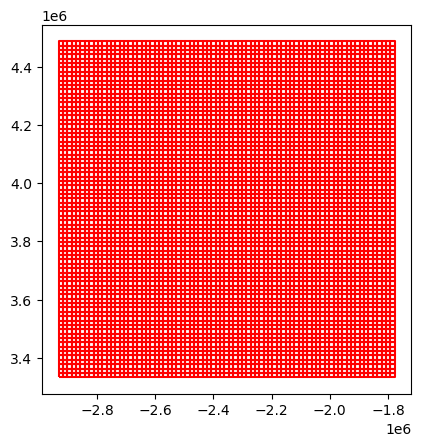

In [118]:
# This handles dateline tiles correctly - even without FIX_DATELINE
fishnet_gdf = do_gee_download_by_subtile.create_fishnet_new(asset_gdf[asset_gdf.agg_tile_num == 16].to_crs(boreal_tiles.crs), TILE_SIZE_M*30, 'agg_tile_num', FIX_DATELINE=False)
fishnet_gdf.boundary.plot(color='red')
fishnet_gdf.tail()
fishnet_gdf.explore()

geometry
5771  POLYGON ((-1851960.000 4472820.000, -1851960.0...
5772  POLYGON ((-1836960.000 4472820.000, -1836960.0...
5773  POLYGON ((-1821960.000 4472820.000, -1821960.0...
5774  POLYGON ((-1806960.000 4472820.000, -1806960.0...
5775  POLYGON ((-1791960.000 4472820.000, -1791960.0...

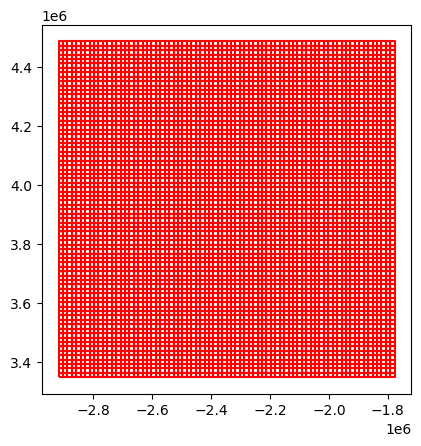

In [116]:
# This handles dateline tiles wrong
fishnet_gdf_old = do_gee_download_by_subtile.create_fishnet(asset_df[asset_df.AGG_TILE_NUM == 16], TILE_SIZE_M)
fishnet_gdf_old.boundary.plot(color='red')
fishnet_gdf_old.explore()
fishnet_gdf_old.tail()

In [65]:
#ax=boreal_tiles_agg_new_updated_dateline[boreal_tiles_agg_new_updated_dateline.agg_tile_num == 10].boundary.plot()



In [121]:
import ee
import ee_download
import zipfile
# Change region CRS to that of the export tifs
SUBTILE_LOC = 702#3193
ID_COL = 'AGG_TILE_NUM'
ID_NUM = 16
OUTDIR_TEST = '/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST4'

if True:
    # Using new fishnet, everything is -9999
    minx, miny, maxx, maxy = fishnet_gdf.to_crs(4326).iloc[SUBTILE_LOC].geometry.bounds
else:
    # Using old fishnet - we see data - but for test SUBLOCS we get lots of unbounded image errors
    minx, miny, maxx, maxy = fishnet_gdf_old.to_crs(4326).iloc[SUBTILE_LOC].geometry.bounds


region_4326 = ee.Geometry.BBox(minx, miny, maxx, maxy)

# I thought this would bring the crs and the geometry needed 
#region  = fishnet.iloc[SUBTILE_LOC]#.geometry

# We want to submit to DPS this...
#print('Fetching..')
print(asset_df[asset_df[ID_COL] == ID_NUM]['id'].iloc[0])
downloaded_image_fn = ee_download.download_image_by_asset_path(
                        asset_path = asset_df[asset_df[ID_COL] == ID_NUM]['id'].iloc[0], #asset_df.iloc[TILELOC]['id'],
                        output_folder = OUTDIR_TEST,
                        region = region_4326,
                        #crs = fishnet.crs,
                        idx = str(SUBTILE_LOC)
                        )
print(downloaded_image_fn)
with zipfile.ZipFile(downloaded_image_fn, 'r') as zip_ref:
    zip_ref.extractall(OUTDIR_TEST)

projects/foreststructure/Circumboreal/S1_triseason_albers_2019/s1_vv_vh_gamma_2019_pwr_tile16
/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST4/s1_vv_vh_gamma_2019_pwr_tile16-subtile000702.zip


### Create a better fishnet of subtiles

#### Dont try to fix dateline here - just get the subtiles 

In [51]:
# import geopandas as gpd
# from shapely.geometry import Polygon

# def create_fishnet_new(gdf, cell_size_meters, tile_col_name, subtile_col_name='subtile_num', FIX_DATELINE=False):
#     """
#     Create a fishnet of vector polygons that fully cover each polygon in the input GeoDataFrame.

#     Parameters:
#     - gdf (geopandas.GeoDataFrame): Input GeoDataFrame with polygons.
#     - cell_size_meters (float): Size of each grid cell in meters.

#     Returns:
#     - geopandas.GeoDataFrame: GeoDataFrame containing the fishnet polygons.
#     """
#     # Ensure the GeoDataFrame has a valid geometry column
#     if 'geometry' not in gdf.columns or gdf['geometry'].isna().any():
#         raise ValueError("The GeoDataFrame must have a valid 'geometry' column with polygons.")

#     fishnet_gdf_list = []
    
#     # Iterate through each polygon in the input GeoDataFrame
#     for _, row in gdf.iterrows():
#         polygon = row['geometry']
#         tile_num = row[tile_col_name]
#         # Get the bounding box of the polygon and extend it to ensure full coverage
#         bounds = polygon.bounds
#         extended_bounds = (
#             bounds[0] - cell_size_meters,
#             bounds[1] - cell_size_meters,
#             bounds[2] + cell_size_meters,
#             bounds[3] + cell_size_meters
#         )

#         # Create a fishnet for the current polygon
#         fishnet_cells = create_fishnet_cells(extended_bounds, cell_size_meters)

#         # Append the fishnet cells to the fishnet GeoDataFrame
#         fishnet_gdf_tmp = gpd.GeoDataFrame({tile_col_name: [tile_num for i in range(len(fishnet_cells))], subtile_col_name: [i for i in range(len(fishnet_cells))]}, geometry=fishnet_cells, crs=gdf.crs)
#         if FIX_DATELINE:
#             # Fix dateline
#             fishnet_gdf_tmp = split_polygons_by_dateline_poly(fishnet_gdf_tmp, tile_num_col=subtile_col_name)
#         fishnet_gdf_tmp[tile_col_name] = tile_num # this converts NULL to the actual tile num for the new polys resulting from the split
#         fishnet_gdf_list.append(fishnet_gdf_tmp)
        
#     fishnet_gdf = pd.concat(fishnet_gdf_list)
#     return fishnet_gdf

# def create_fishnet_cells(bounds, cell_size):
#     """
#     Create fishnet cells for a given bounding box and cell size.

#     Parameters:
#     - bounds (tuple): Bounding box coordinates (minx, miny, maxx, maxy).
#     - cell_size (float): Size of each grid cell.

#     Returns:
#     - List of shapely.geometry.Polygon: List of fishnet cells.
#     """
#     minx, miny, maxx, maxy = bounds
#     rows = int((maxy - miny) / cell_size)
#     cols = int((maxx - minx) / cell_size)

#     fishnet_cells = []
#     for i in range(rows):
#         for j in range(cols):
#             x = minx + j * cell_size
#             y = miny + i * cell_size
#             cell = Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
#             fishnet_cells.append(cell)

#     return fishnet_cells

# # Example usage:
# # This works with boreal agg tiles
# gdf = boreal_tiles_agg_new_updated_dateline#[boreal_tiles_agg_new_updated_dateline.agg_tile_num == 9]
# # This does not work with the tiles created from the asset_df
# gdf = asset_gdf.to_crs(boreal_tiles.crs)

# # Assuming gdf is your GeoDataFrame and you want a fishnet with 500-meter cells
# gdf_fishnet = create_fishnet_new(gdf, cell_size_meters=500*30, tile_col_name='agg_tile_num')

# # Fix dateline
# #gdf_fishnet = split_polygons_by_dateline_poly(gdf_fishnet, tile_num_col='subtile_num')#.drop('index_right')

# # # Plot the original polygons and the fishnet for visual verification
# # fig, ax = plt.subplots(figsize=(10, 10))
# # gdf.plot(ax=ax, edgecolor='black', facecolor='none', lw=2)
# # gdf_fishnet.plot(ax=ax, edgecolor='blue', facecolor='none', lw=1)
# # plt.title('Original Polygons and Fishnet')
# # plt.show()
# # gdf_fishnet.explore()

Text(0.5, 1.0, 'Updated boreal tiles v004 & aggregate tiles with dateline fix & subtiles for 2019')

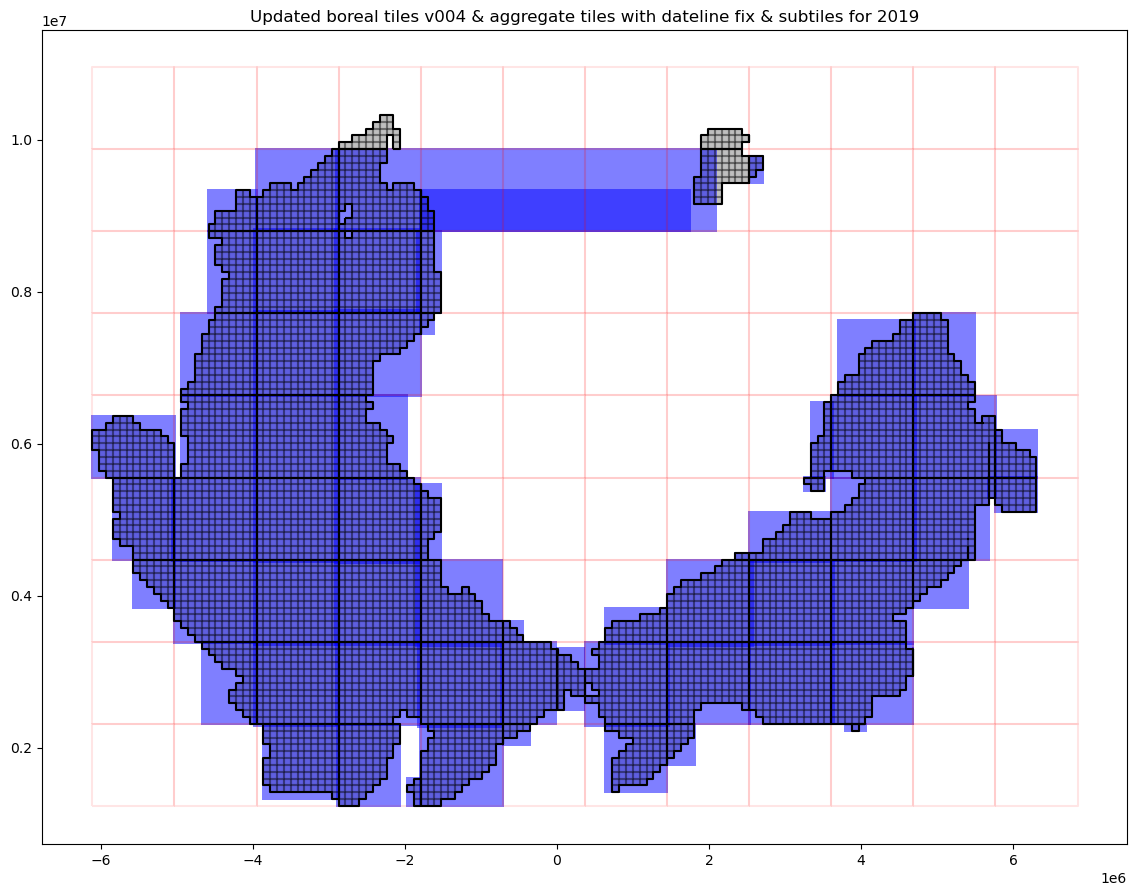

In [56]:
ax = boreal_tiles_agg_new.boundary.plot(color='red', alpha=0.1, figsize=(14,14))
ax = boreal_tiles_agg_new_updated_dateline.boundary.plot(color='black', ax=ax)
#ax = bad_agg_tile.plot(ax=ax, color='black')
ax = boreal_tiles_updated.boundary.plot(ax=ax, color='black', alpha=0.25)
#ax = boreal_tiles_agg_new_updated_dateline.plot(ax=ax, column='agg_tile_num', color = [np.random.choice(list(mcolors.CSS4_COLORS.values())) for i in range(400)] )
ax = boreal_tiles_agg_new_updated_dateline.plot(ax=ax, color='black', alpha=0.25)
ax = fishnet_gdf.to_crs(boreal_tiles.crs).plot(ax=ax, color='blue', alpha=0.5)
ax.set_title(f'Updated boreal tiles {UPDATED_BOREAL_TILES_VERSION} & aggregate tiles with dateline fix & subtiles for {YEAR}')

In [45]:
fishnet_gdf

agg_tile_num  subtile_num  \
0               1            0   
1               1            1   
2               1            2   
3               1            3   
4               1            4   
..            ...          ...   
155            54          155   
156            54          156   
157            54          157   
158            54          158   
159            54          159   

                                              geometry  
0    POLYGON ((1433497.652 1758284.767, 1448497.652...  
1    POLYGON ((1448497.652 1758284.767, 1463497.652...  
2    POLYGON ((1463497.652 1758284.767, 1478497.652...  
3    POLYGON ((1478497.652 1758284.767, 1493497.652...  
4    POLYGON ((1493497.652 1758284.767, 1508497.652...  
..                                                 ...  
155  POLYGON ((5708505.665 5553224.122, 5723505.665...  
156  POLYGON ((5723505.665 5553224.122, 5738505.665...  
157  POLYGON ((5738505.665 5553224.122, 5753505.665...  
158  POLYGON ((5753505.665 5553224.122, 5768505.665...  
159  POLYGON ((5768505.665 5553224.122, 5783505.665...  

[190123 rows x 3 columns]

## This is a start for how to now DPS this

In [141]:
fishnet_gdf.explore()

## To set up DPS

### need asset df converted to asset gdf LOCALLY for fishnet gdf creation to that tile & subtile combos sent to DPS match what is REMOTELY processing

In [150]:
import importlib
import do_gee_download_by_subtile
importlib.reload(do_gee_download_by_subtile)

<module 'do_gee_download_by_subtile' from '/projects/code/icesat2_boreal/lib/do_gee_download_by_subtile.py'>

In [61]:
!aws s3 rm --recursive s3://maap-ops-workspace/shared/montesano/local_output/do_gee_download_by_subtile_TEST4

/bin/bash: line 1: aws: command not found


In [167]:
#### If DPSing by subtile, you need ASSET_PATH to get gee asset_df and TILELOC to get the tile form asset_df to make its fishnet even before you call 'do_gee_download_by_subtile'
ASSET_PATH = f'projects/foreststructure/Circumboreal/S1_triseason_albers_{YEAR}'

# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

TILE_FIELD_NAME = 'AGG_TILE_NUM' # in CAPS in asset_df ; lower  
TILE_SIZE_M = 500
GRID_SIZE_M = 30

In [161]:
input_coordinates_list = [asset_df['system:footprint'][i]['coordinates'] for i, TILE_NUM in enumerate(asset_df[TILE_FIELD_NAME].to_list())]
input_tiles_list = [TILE_NUM for i, TILE_NUM in enumerate(asset_df[TILE_FIELD_NAME].to_list())]

# Create a GeoDataFrame with the polygon
asset_gdf = pd.concat([do_gee_download_by_subtile.create_polygon_from_coordinates(input_coordinates) for input_coordinates in input_coordinates_list], ignore_index=True)
asset_gdf = pd.concat([asset_gdf, pd.DataFrame({TILE_FIELD_NAME : input_tiles_list})], axis=1)

### Shows the GEE-derived asset gdf (blue) vs the local updated agg tiles (red)

### `TODO`: how to remotely produce the nice updated agg tiles so subtile generation isnt a mess of extra water tiles...

In [173]:
m = asset_gdf.explore()
boreal_tiles_agg_new_updated_dateline.explore(m=m, color='red')

In [166]:

#fishnet_gdf = do_gee_download_by_subtile.create_fishnet_new(asset_gdf.to_crs(boreal_tiles.crs), 500*30, 'agg_tile_num')
OUTDIR_TMP = '/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST4'
!mkdir -p $OUTDIR_TMP

CREDS_FN = 's3://maap-ops-workspace/montesano/credentials'

LIST_in_param_dict = []

#for index, row in asset_gdf.head(20).tail(1).iterrows():
for index, row in asset_gdf.iterrows():
    tile_num = row[TILE_FIELD_NAME]
    
    # Get a agg tile specific fishnet to iterate over
    fishnet_gdf = do_gee_download_by_subtile.create_fishnet_new(asset_gdf[asset_gdf[TILE_FIELD_NAME] == tile_num], TILE_SIZE_M * GRID_SIZE_M, TILE_FIELD_NAME, FIX_DATELINE=False) # Dateline subtiles will still fail regardless - maybe ok?

    #for index, row in fishnet_gdf.head(500).tail(1).iterrows():
    for index, row in fishnet_gdf.iterrows():
        subtile_num = row['subtile_num']
        
        # Put a check here for intersection with boreal_tiles - dont want subtiles out in the ocean
        
        if False:
            # Local tests like this
            do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=subtile_num, ID_NUM=tile_num, ID_COL=TILE_FIELD_NAME, ASSET_PATH=ASSET_PATH, TILE_SIZE_M=TILE_SIZE_M, OUTDIR=OUTDIR_TMP)
        else:
            # Need params list for DPS
            in_param_dict = {
                                'creds_fn' : CREDS_FN,
                                 'subtile_loc': subtile_num,
                                 'id_num': tile_num,
                                 'id_col': TILE_FIELD_NAME,
                                 'tile_size_m': TILE_SIZE_M,
                                 'asset_path': ASSET_PATH

                }

            LIST_in_param_dict.append(in_param_dict)
len(LIST_in_param_dict)            

329109

In [169]:
fishnet_gdf.explore()

# -----------------------------------------

# Old Approach 

### Remove dateline tiles from original agg file

In [26]:
if False:
    # Open previously generated 'aggregate' tiles vector
    #boreal_tiles_agg = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg10_bb_4326.gpkg').to_crs(boreal_tiles.crs)
    boreal_tiles_agg = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9.gpkg').to_crs(boreal_tiles.crs)
    boreal_tiles_agg.plot()
    new_geometry = boreal_tiles_agg['geometry'].difference(boreal_tiles_dateline.unary_union)
    new_geometry.plot()
    boreal_tiles_agg_sub = gpd.GeoDataFrame(geometry=new_geometry)
    boreal_tiles_agg_sub['agg_tile_num'] = boreal_tiles_agg_sub.index + 1
    boreal_tiles_agg_sub.plot(column='agg_tile_num')

### Clean up the dateline

In [27]:
#world_ = gpd.read_file('/projects/my-public-bucket/databank/continents.shp').cx[-180:180, 45:90]

In [28]:
agg_bounds = boreal_tiles_agg_new.total_bounds

In [29]:
dateline_tiles_box = list(boreal_tiles_dateline.total_bounds)
print(dateline_tiles_box)
dateline_tiles_box = [dateline_tiles_box[0] , agg_bounds[1], dateline_tiles_box[2], agg_bounds[3]] 
dateline_tiles_box

[-81478.00000000466, 2493304.0000000093, 8521.999999995343, 3303304.0000000093]


[-81478.00000000466, 1233304.0000000093, 8521.999999995343, 10953304.00000001]

<Axes: >

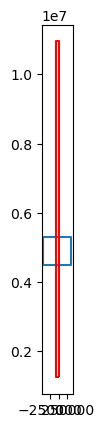

In [30]:
dateline_geom = shapely.geometry.box(*dateline_tiles_box)
dateline_geom_gdf = gpd.GeoDataFrame(crs = boreal_tiles.crs, geometry=[dateline_geom])
ax = boreal_tiles_agg_new.head(72).tail(1).boundary.plot()
dateline_geom_gdf.boundary.plot(ax=ax, ec='red')

In [31]:
import numpy as np
import matplotlib.colors as mcolors

### Get only AGG tiles that intersect boreal tiles
#### Make sure that each polygon is unique
explode

In [32]:
new_geom = gpd.sjoin(boreal_tiles_agg_new, boreal_tiles[['map_version','geometry']], predicate='intersects').dissolve('agg_tile_num').difference(dateline_geom_gdf.unary_union)
boreal_tiles_agg_new_sub = gpd.GeoDataFrame(geometry = new_geom, crs = boreal_tiles.crs).explode()

boreal_tiles_agg_new_sub.reset_index(inplace=True)
boreal_tiles_agg_new_sub['agg_tile_num'] = boreal_tiles_agg_new_sub.index + 1
boreal_tiles_agg_new_sub = boreal_tiles_agg_new_sub.reset_index(drop=True).drop(['level_1'], axis=1)

# Orig list of agg tiles is used to subset gdf from new dateline approach
sub_agg_tile_list = boreal_tiles_agg_new_sub.agg_tile_num.to_list()

/tmp/ipykernel_23375/2022229765.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boreal_tiles_agg_new_sub = gpd.GeoDataFrame(geometry = new_geom, crs = boreal_tiles.crs).explode()


In [33]:
# # Split polygons by the international date line
# boreal_tiles_agg_new_sub_updated = split_polygons_by_dateline_poly(boreal_tiles_agg_new[boreal_tiles_agg_new.agg_tile_num.isin(sub_agg_tile_list)].head(72), tile_num_col='agg_tile_num')

In [34]:
bad_agg_tile = boreal_tiles_agg_new[boreal_tiles_agg_new.agg_tile_num.isin(sub_agg_tile_list)].head(72).tail(1)
bad_agg_tile

geometry  agg_tile_num
71  POLYGON ((-441478.000 4473304.000, -441478.000...            72

In [35]:
# xmin, ymin, xmax, ymax = [int(x) for x in boreal_tiles_agg_new_sub.total_bounds]
# boreal_tiles_agg_new_sub = boreal_tiles_agg_new_sub.cx[xmin:xmax, ymin:ymax]

<Axes: >

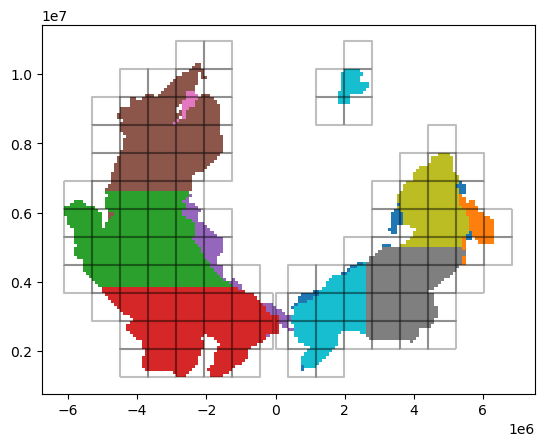

In [36]:
ax = boreal_tiles.plot(column='tile_group')
boreal_tiles_agg_new_sub.boundary.plot(ax=ax, ec='black', alpha = 0.25)

In [37]:
print(f"{len(boreal_tiles_agg_new_sub)} agg tiles you'll have to export from GEE for each year's seasonal composite")

110 agg tiles you'll have to export from GEE for each year's seasonal composite


## At AGG_FACTOR=20, polygons 19 and 24 extend too far north and fail to export in GEE

In [38]:

PROBLEM_TILES_LIST = [19,24,29,31]
EMPTY_TILES_LIST = []


if AGG_FACTOR==20:
    
    # These AGG tiles do not have boreal_tiles - remove
    EMPTY_TILES_LIST = [1,8]
    
    # Get AGG tiles with problems
    problem_tiles_gdf = boreal_tiles_agg_new_sub[boreal_tiles_agg_new_sub.agg_tile_num.isin(PROBLEM_TILES_LIST)]
    
    # Clip boreal tiles to extent of fix tiles
    boreal_tiles_clip_tmp = boreal_tiles.clip(problem_tiles_gdf)
    print(boreal_tiles_clip_tmp.total_bounds)
    
    # Plot to check
    ax = boreal_tiles_clip_tmp.plot(column='tile_group', ec='black')
    problem_tiles_gdf.boundary.plot(ax=ax, ec='black', alpha = 0.25)

    # Get bbox from clipped boreal_tiles
    new_box = list(boreal_tiles_clip_tmp.total_bounds)
    # ... actually get bboc from clipped boreal tiles + some more in the x direction
    new_box = [new_box[0] , new_box[1], new_box[2] + 2e5, new_box[3]] 
    print(new_box)
    
    # Make gdf of new box
    new_tiles_geom = shapely.geometry.box(*new_box)
    new_tiles_geom_gdf = gpd.GeoDataFrame(crs = boreal_tiles.crs, geometry=[new_tiles_geom])
    
    # Plot fix extent to check
    ax = boreal_tiles_clip_tmp.plot(column='tile_group', ec='black')
    ax = problem_tiles_gdf.boundary.plot(ax=ax, ec='black', alpha = 0.25)
    new_tiles_geom_gdf.boundary.plot(ax=ax, ec='red')
    
    # Clip fix tiles by new tiles gdf
    fixed_tiles_gdf = problem_tiles_gdf.clip(new_tiles_geom_gdf)
    
    

## Clean up AGG_TILE_NUM

In [39]:
if AGG_FACTOR==20:
    #fixed_tiles_gdf.reset_index(inplace=True)
    boreal_tiles_agg_new_sub_FIXED = pd.concat([fixed_tiles_gdf, boreal_tiles_agg_new_sub[~boreal_tiles_agg_new_sub.agg_tile_num.isin(PROBLEM_TILES_LIST + EMPTY_TILES_LIST)]])
    boreal_tiles_agg_new_sub_FIXED = boreal_tiles_agg_new_sub_FIXED.sort_values(by=['agg_tile_num'], ascending=True)
    boreal_tiles_agg_new_sub_FIXED.reset_index(inplace=True, drop=True)
    #boreal_tiles_agg_new_sub_FIXED.reset_index(inplace=True)
    #boreal_tiles_agg_new_sub_FIXED.drop('index', inplace=True)
    boreal_tiles_agg_new_sub_FIXED['agg_tile_num'] = boreal_tiles_agg_new_sub_FIXED.index + 1

    boreal_tiles_agg_new_sub_FIXED.tail()
    
    OUT_TILES_GDF = boreal_tiles_agg_new_sub_FIXED

else:
    
    OUT_TILES_GDF = boreal_tiles_agg_new_sub

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

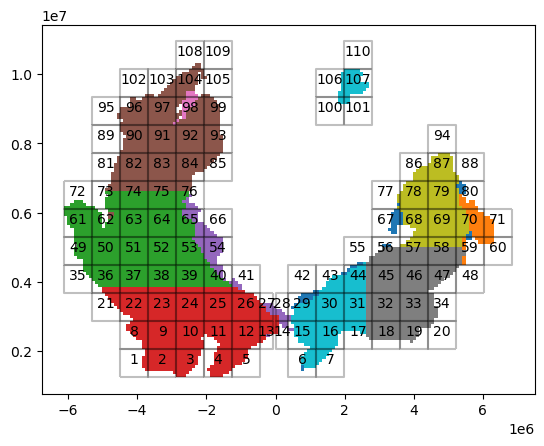

In [41]:
ax = boreal_tiles.plot(column='tile_group')


if True:
    tmp = OUT_TILES_GDF.copy()
    tmp.boundary.plot(ax=ax, ec='black', alpha = 0.25)
    
    tmp['coords'] = tmp['geometry'].apply(lambda x: x.representative_point().coords[:])
    tmp['coords'] = [coords[0] for coords in tmp['coords']]

    for idx, row in tmp.iterrows():
        plt.annotate(text=row['agg_tile_num'], xy=row['coords'],horizontalalignment='center')
        


In [42]:
OUT_TILES_GDF.columns

Index(['agg_tile_num', 'geometry'], dtype='object')

In [43]:
# OUT_TILES_GDF = OUT_TILES_GDF.drop(['coords'])
# OUT_TILES_GDF.info()

In [44]:
OUT_TILES_GDF.to_crs(4326).to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}/boreal_tiles_v003_agg{AGG_FACTOR}_4326.shp' )
#OUT_TILES_GDF.to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}.shp' )
OUT_TILES_GDF.to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}/boreal_tiles_v003_agg{AGG_FACTOR}.gpkg' )

/tmp/ipykernel_23375/1754384940.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  OUT_TILES_GDF.to_crs(4326).to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}/boreal_tiles_v003_agg{AGG_FACTOR}_4326.shp' )


In [45]:
AGG_FACTOR

9